# VOICE CLONING AND FAKE AUDIO DETECTION 

## PHASE 1 - VOICE CLONING SYSTEM (VCS)

### CONTEXT 

The client is a tech company working in the Cyber Security industry. They developed end-to-end products and services that ensure the customers security using data driven technologies to understand whether audio and video media is authentic or fake/synthetic.

### GOALS

- Build a VCS (Voice Cloning System) that takes real/authentic audio samples, applies signal transformations, and generates their synthetic clones.
- Develop a FAD (Fake Audio Detection) using a ground truth audio dataset, that uses Machine Learning to detect whether the audio is fake or not.

### SUCCESS METRICS
- Word Error Rate (WER) for automatic evaluation of the VCS.
- Speaker classification accuracy to assess the performance of the generated audio’s target speaker.
- Classification metrics like F-1 Score via positive labels coming from the groundtruth dataset and negative labels generated by the VCS.

### DATA DESCRIPTION

For this project, we will be leveraging the following two datasets: 

- TIMIT dataset - contains speech data for acoustic-phonetic studies and for the development and evaluation of automatic speech recognition systems. TIMIT contains a total of 6300 sentences, 10 sentences spoken by each of 630 speakers from 8 major dialect regions of the United States. Our VCS will create 5 clones per speaker id.

- CommonVoice dataset - corpus of speech data read by users on the Common Voice website (https://commonvoice.mozilla.org/), and based upon text from a number of public domain sources like user submitted blog posts, old books, movies, and other public speech corpora. Its primary purpose is to enable the training and testing of automatic speech recognition (ASR) systems. Link - [https://commonvoice.mozilla.org/en/datasets]

### METHODOLOGY

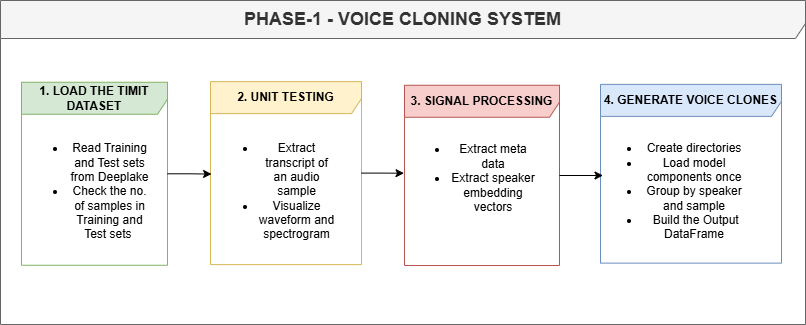

In [1]:
import deeplake
# import data analysis libraries  

import pandas as pd
import math
import random
import numpy as np
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
import deeplake
# import libraries for data visualization
plt.style.use('seaborn-v0_8-darkgrid')  # Seaborn-like

print('imported all dependencies...')

C:\Users\Pratyush Karna\AppData\Local\Programs\Python\Python311\Lib\site-packages\humbug\report.py:47: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # type: ignore
C:\Users\Pratyush Karna\AppData\Local\Programs\Python\Python311\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (4.3.5) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


imported all dependencies...


## STEP - 1 : LOAD THE TIMIT DATASET

We will use the deeplake library to load the timit dataset in read only made and gather them locally in the project directory as standardized, usable dataset. 

In [2]:
# Load training and test data from TIMIT dataset
ds_train = deeplake.load("hub://activeloop/timit-train")
ds_test  = deeplake.load("hub://activeloop/timit-test")

print("Number of samples in the Training Set:", len(ds_train))
print("Number of samples in the Test Set:", len(ds_test))

# tensors() is a method in some versions, an attribute in others — handle both:
t_train = ds_train.tensors() if callable(getattr(ds_train, "tensors", None)) else ds_train.tensors
t_test  = ds_test.tensors()  if callable(getattr(ds_test,  "tensors", None)) else ds_test.tensors

print("Tensors in the training set:", list(t_train.keys()))
print("Tensors in the test set    :", list(t_test.keys()))

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/timit-train



|

hub://activeloop/timit-train loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/timit-test



-

hub://activeloop/timit-test loaded successfully.

Number of samples in the Training Set: 4620
Number of samples in the Test Set: 1680
Tensors in the training set: ['audios', 'dialects', 'is_phoenetics', 'is_sentences', 'is_word_files', 'speaker_ids', 'texts']
Tensors in the test set    : ['audios', 'dialects', 'is_phoenetics', 'is_sentences', 'is_word_files', 'speaker_ids', 'texts']


## STEP - 2 : UNIT TEST AN AUDIO SAMPLE

Select a random real TIMIT audio sample and visualize how its amplitude and frequency changes over the time of the clip. 

### EXTRACT TRANSCRIPT OF THE AUDIO SAMPLE

In [3]:
# Pick the first audio sample from the training set
audio_entry = ds_train['audios'][0]
text_entry  = ds_train['texts'][0]
spk_entry   = ds_train['speaker_ids'][0] if 'speaker_ids' in t_train else None

# audio as numpy (squeezed to [T])
audio_np = np.asarray(audio_entry.numpy()).squeeze()
print("audio dtype/shape:", audio_np.dtype, audio_np.shape)

# text as str (deeplake Text can yield str or bytes depending on version)
text_val = text_entry.data()
if isinstance(text_val, bytes):
    text_str = text_val.decode('utf-8', errors='ignore')
else:
    text_str = str(text_val)

print("transcript:", text_str)
if spk_entry is not None:
    print("speaker_id:", spk_entry.numpy())

audio dtype/shape: float64 (39834,)
transcript: {'value': np.str_('Publicity and notoriety go hand in hand.')}
speaker_id: [409]


In [4]:
# play this audio sample and verify with the transcript 
from IPython.display import Audio
sr = 16000  # TIMIT sample rate
Audio(audio_np, rate=sr)

### ANALYZE AMPLITUDE AND FREQUENCY OVER TIME

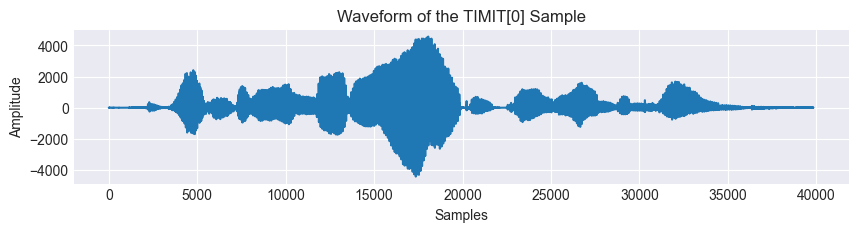

In [5]:
import IPython.display as ipd

sr = 16000
ipd.Audio(audio_np.squeeze(), rate=sr)

plt.figure(figsize=(10, 2))
plt.plot(audio_np.squeeze())
plt.title("Waveform of the TIMIT[0] Sample")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

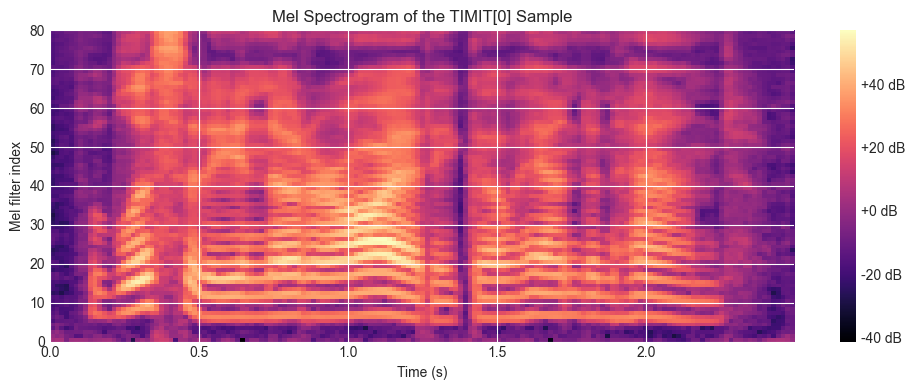

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

# --- Parameters ---
sr = 16000
n_fft = 1024
hop_length = 256
n_mels = 80

# --- Compute STFT ---
f, t, Zxx = stft(audio_np.squeeze(), fs=sr, nperseg=n_fft, noverlap=n_fft - hop_length)
S = np.abs(Zxx) ** 2  # Power spectrogram

# --- Create Mel filterbank ---
def mel_filterbank(sr, n_fft, n_mels):
    # Convert Hz <-> Mel
    def hz_to_mel(hz): return 2595 * np.log10(1 + hz / 700)
    def mel_to_hz(mel): return 700 * (10**(mel / 2595) - 1)
    
    # Mel scale points
    mel_points = np.linspace(hz_to_mel(0), hz_to_mel(sr // 2), n_mels + 2)
    hz_points = mel_to_hz(mel_points)
    
    # Bin frequencies
    bin_freqs = np.floor((n_fft + 1) * hz_points / sr).astype(int)
    
    # Create triangular filters
    fb = np.zeros((n_mels, n_fft // 2 + 1))
    for m in range(1, n_mels + 1):
        f_m_minus, f_m, f_m_plus = bin_freqs[m - 1:m + 2]
        for k in range(f_m_minus, f_m):
            fb[m - 1, k] = (k - f_m_minus) / (f_m - f_m_minus)
        for k in range(f_m, f_m_plus):
            fb[m - 1, k] = (f_m_plus - k) / (f_m_plus - f_m)
    return fb

mel_fb = mel_filterbank(sr, n_fft, n_mels)
mel_spectrogram = np.dot(mel_fb, S)

# --- Convert to dB scale ---
S_dB = 10 * np.log10(np.maximum(mel_spectrogram, 1e-10))

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.imshow(S_dB, origin='lower', aspect='auto', 
           extent=[t.min(), t.max(), 0, n_mels], cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram of the TIMIT[0] Sample")
plt.xlabel("Time (s)")
plt.ylabel("Mel filter index")
plt.tight_layout()
plt.show()

#### OBSERVATIONS

**Waveform:**
- The waveform shows clear voiced regions with strong amplitude between roughly 0.5–1.5 s, indicating active speech segments separated by short silences.
- Peak amplitudes reach around ±4000, suggesting consistent but not clipped recording levels.
- The beginning and end are mostly quiet - like in any natural speech - evident from the wavelength zeroeing down.

**Spectrogram:**
- The spectrogram reveals distinct harmonic bands and formant structures, characteristic of voiced phonemes.
- Intensity is concentrated below ~4 kHz, tapering off in higher Mel bands - expected for human speech.
- The alternating high-intensity and low-intensity regions correspond to possibly consonant–vowel or other syllable transitions.
- Just like the waveform, the start and the end are quiet - here evident from the dark purple regions, where the signal zeroes down.

## STEP - 3 : SIGNAL PROCESSSING

In [7]:
# Test the pytorch function on the audio sample 
import torch

model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad', force_reload=False)
(get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks) = utils

speech_timestamps = get_speech_timestamps(audio_np, model, sampling_rate=16000)
speech_timestamps

Using cache found in C:\Users\Pratyush Karna/.cache\torch\hub\snakers4_silero-vad_master


[{'start': 5152, 'end': 15840}, {'start': 18976, 'end': 37344}]

In [8]:
'''
Safety Cell - to ensures stable threading and avoid kernel crashes and limit CPU threading.
'''
import os

# Limit CPU threading to prevent oversubscription (Torch + MKL + OpenMP)
os.environ["OMP_NUM_THREADS"] = "16"
os.environ["MKL_NUM_THREADS"] = "16"

# Set Torch threading limits (must run BEFORE any torch ops!)
torch.set_num_threads(16)
# You can also uncomment the next line if kernel is freshly restarted
# torch.set_num_interop_threads(1)

print("PyTorch threading configured safely...")

PyTorch threading configured safely...


### EXTRACT META DATA 

In [9]:
from tqdm import tqdm
import numpy as np
import pandas as pd

'''
save_meta_data() : function to save the meta data of each audio clip - speaker id, timestamps and audio transcript
@params : data - the TIMIT dataset read from deeplake, filepath - define the path where to save the csv file 
@return : None
'''

def save_meta_data(data, filepath):
    processed = []
    N = len(data)   # or set N = 100 for testing
    print(f"Processing {N} TIMIT samples...")

    for i in tqdm(range(N)):
        try:
            # 1. Extract audio and metadata
            audio_np = np.asarray(data['audios'][i].numpy()).squeeze()

            text_val = data['texts'][i].data()
            text_str = (
                text_val.decode('utf-8', errors='ignore')
                if isinstance(text_val, bytes)
                else str(text_val)
            )

            spk_id = (
                data['speaker_ids'][i].numpy().item()
                if 'speaker_ids' in data.tensors
                else None
            )

            # 2. Run VAD
            speech_timestamps = get_speech_timestamps(audio_np, model, sampling_rate=16000)

            # 3. Compute speech ratio
            total_len = len(audio_np)
            speech_len = sum([s['end'] - s['start'] for s in speech_timestamps])
            speech_ratio = speech_len / total_len if total_len > 0 else 0

            # 4. Append result
            processed.append({
                "index": i,
                "speaker_id": spk_id,
                "transcript": text_str,
                "speech_ratio": speech_ratio,
                "num_segments": len(speech_timestamps),
                "timestamps": speech_timestamps,
            })

        except Exception as e:
            print(f"⚠️ Error processing index {i}: {e}")
            continue

    # 5. Save DataFrame
    df_timit = pd.DataFrame(processed)
    os.makedirs("metadata", exist_ok=True)
    df_timit.to_csv(filepath, index=False)

    print(f"\n✅ Processed {len(df_timit)} samples successfully!")
    df_timit.head()


In [10]:
# run the function on TIMIT train and test sets and save their meta data
# uncomment to save locally in the project directory

# save_meta_data(ds_train, "metadata/TIMIT_Dataset_Sounds_Metadata_Train.csv")
# ave_meta_data(ds_test, "metadata/TIMIT_Dataset_Sounds_Metadata_Test.csv")

### EXTRACT SPEAKER EMBEDDING VECTORS

In [11]:
from speechbrain.inference.speaker import SpeakerRecognition
import numpy as np
from tqdm import tqdm
import pandas as pd


'''
extract_embeddings() : function to extract the embedding of each audio sample - in vector form 
@params : df_timit - pandas dataframe where metadata is stored, filepath - define the path where to save the embeddings csv file 
@return : None
'''

def extract_embeddings(df_timit, filepath):
    # Load the pretrained speaker recognition model
    recog = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

    speaker_embeds = []

    unique_speakers = df_timit['speaker_id'].unique()
    print(f"Found {len(unique_speakers)} unique speakers in TIMIT.")

    for spk in tqdm(unique_speakers):
        try:
            # pick first sample from this speaker
            spk_rows = df_timit[df_timit['speaker_id'] == spk]
            idx = int(spk_rows.iloc[0]['index'])

            # fetch the audio
            audio_entry = ds_train['audios'][idx]
            audio_np = np.asarray(audio_entry.numpy()).squeeze()

            # ensure float32
            audio_tensor = torch.tensor(audio_np).float()

            # compute embedding
            emb = recog.encode_batch(audio_tensor.unsqueeze(0))
            emb_np = emb.squeeze().detach().cpu().numpy()

            speaker_embeds.append({
                "speaker_id": spk,
                "embedding_vector": emb_np
            })
        except Exception as e:
            print(f"⚠️ Error processing speaker {spk}: {e}")
            continue

    # ✅ Store as DataFrame
    df_speakers = pd.DataFrame(speaker_embeds)
    print(f"\n✅ Extracted embeddings for {len(df_speakers)} speakers.")
    df_speakers.to_csv(filepath, mode='w')
    df_speakers.head()

In [12]:
# Read the meta data extracted from save_meta_data into pandas dataframes
df_meta_train = pd.read_csv("metadata/TIMIT_Dataset_Sounds_Metadata_Train.csv")
df_meta_test = pd.read_csv("metadata/TIMIT_Dataset_Sounds_Metadata_Test.csv")

# Uncommented the following two function calls to get the speakers embedding and save locally accordingly

# extract_embeddings(df_meta_train, 'metadata/TIMIT_Dataset_Sounds_Embedding_Vectors_Train.csv')
# extract_embeddings(df_meta_train, 'metadata/TIMIT_Dataset_Sounds_Embedding_Vectors_Test.csv')

In [13]:
# Check the first few rows of the training set's metadata
df_meta_train.head()

,index,speaker_id,transcript,speech_ratio,num_segments,timestamps
0,0,409,{'value': np.str_('Publicity and notoriety go ...,0.729427,2,"[{'start': 5152, 'end': 15840}, {'start': 1897..."
1,1,409,{'value': np.str_('She had your dark suit in g...,0.780523,2,"[{'start': 4640, 'end': 10720}, {'start': 1232..."
2,2,409,{'value': np.str_('Is it anything like cooked-...,0.722860,2,"[{'start': 2080, 'end': 14816}, {'start': 2051..."
3,3,409,{'value': np.str_('Biblical scholars argue his...,0.580900,1,"[{'start': 12832, 'end': 30618}]"
4,4,409,{'value': np.str_('You always come up with pat...,0.452960,1,"[{'start': 20512, 'end': 38880}]"


In [14]:
# Check the first few rows of the training set's emebedding vectors
df_embeddings_train = pd.read_csv("metadata/TIMIT_Dataset_Sounds_Embedding_Vectors_Train.csv")
df_embeddings_test = pd.read_csv("metadata/TIMIT_Dataset_Sounds_Embedding_Vectors_Test.csv")

df_embeddings_train.head()

,Unnamed: 0,speaker_id,embedding_vector
0,0,409,[-13.063497 3.968644 -5.7455854 34.96...
1,1,433,[ 9.0102035e-01 -2.6834018e+00 -4.1597755e+01 ...
2,2,421,[ 4.036999 5.9368625 -32.862724 -29.59...
3,3,422,[ 8.05816174e+00 -1.60179436e+00 -1.90776310e+...
4,4,404,[ -3.01778 -6.188307 17.339233 -10.59...


## STEP - 4 : GENERATE VOICE CLONES

In [15]:
import os, torch, soundfile as sf
import numpy as np, pandas as pd
from tqdm import tqdm
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

'''
generate_voice_clones() : function to implement the VCS that uses the extracted timit meta data to generate custom audio clones of each speaker
                        using Microsoft's pretrained Speech T5 model  
@params : df_timit - input pandas dataframe where timit metadata is stored, 
          ds - the corresponding deeplake read only audio dataset to the metadata,
          split_name - a keyword to specify whether train or test set is to be processed,
          samples_per_speaker - how many fake-real pairs for each speaker id, preset to 5 which can be updated (TIMIT has 10 samples per speaker)
@return : df_audio - output pandas dataframe that has the audio file path and label (fake/real) 
'''

def generate_voice_clones(df_timit, ds, split_name="train", samples_per_speaker=5):
   
    import os, random, torch, numpy as np, soundfile as sf
    from tqdm import tqdm
    from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

    # ------------------------------------------------------------
    # 1. Create directories
    # ------------------------------------------------------------
    dir_real = f"data/{split_name}/real"
    dir_fake = f"data/{split_name}/fake"
    os.makedirs(dir_real, exist_ok=True)
    os.makedirs(dir_fake, exist_ok=True)

    # ------------------------------------------------------------
    # 2. Load model components once
    # ------------------------------------------------------------
    processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
    model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
    vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

    # Dummy embeddings for now (replace later with real speaker vectors)
    embeddings_dataset = [torch.randn(512) for _ in range(100)]

    # ------------------------------------------------------------
    # 3. Group by speaker and sample
    # ------------------------------------------------------------
    speakers = df_timit["speaker_id"].unique()
    print(f"Found {len(speakers)} unique speakers in dataset.")
    total_generated = 0

    for spk_id in tqdm(speakers, desc=f"Generating {split_name} set"):
        spk_rows = df_timit[df_timit["speaker_id"] == spk_id]
        chosen_rows = spk_rows.sample(min(samples_per_speaker, len(spk_rows)), random_state=42)

        for _, row in chosen_rows.iterrows():
            try:
                idx = int(row["index"])
                text_obj = row["transcript"]
                audio_np = np.asarray(ds["audios"][idx].numpy()).squeeze()

                # --- Clean transcript ---
                if isinstance(text_obj, dict) and "value" in text_obj:
                    text = str(text_obj["value"])
                elif isinstance(text_obj, np.str_):
                    text = str(text_obj)
                else:
                    text = str(text_obj)
                text = text.replace("value", "").replace("{", "").replace("}", "").strip()
                if len(text) == 0:
                    text = "This is a placeholder sentence for speech synthesis."

                # --- Real audio path ---
                real_path = f"{dir_real}/{spk_id}_{idx:04d}.wav"
                if np.max(np.abs(audio_np)) > 0:
                    audio_int16 = np.int16(audio_np / np.max(np.abs(audio_np)) * 32767)
                else:
                    audio_int16 = np.int16(audio_np)
                sf.write(real_path, audio_int16, 16000, subtype="PCM_16")

                # --- Fake audio path ---
                fake_path = f"{dir_fake}/{spk_id}_{idx:04d}.wav"
                inputs = processor(text=text, return_tensors="pt")
                speaker_embedding = embeddings_dataset[hash(spk_id) % len(embeddings_dataset)].unsqueeze(0)
                speech = model.generate_speech(inputs["input_ids"], speaker_embedding, vocoder=vocoder)
                sf.write(fake_path, speech.numpy(), samplerate=16000, subtype="PCM_16")

                total_generated += 1

            except Exception as e:
                print(f"⚠️ Error with speaker {spk_id}, index {row['index']}: {e}")

    print(f"✅ Completed generation: {total_generated} total audios ({split_name})")

    # ------------------------------------------------------------
    # 4. Build the Output DataFrame
    # ------------------------------------------------------------
    from glob import glob
    real_paths = glob(f"{dir_real}/*.wav")
    fake_paths = glob(f"{dir_fake}/*.wav")

    df_audio = pd.DataFrame({
        "path": real_paths + fake_paths,
        "label": [0]*len(real_paths) + [1]*len(fake_paths)
    })
    df_audio.to_csv(f"data/{split_name}_audio_index.csv", index=False)

    print(f"✅ Saved index: data/{split_name}_audio_index.csv")
    print(f"  Real: {len(real_paths)} | Fake: {len(fake_paths)}")

    return df_audio


In [16]:
# Uncomment the following function to generate the real and fake audio samples and build the complete TIMIT dataset

# df_train_audio = generate_voice_clones_v1(df_meta_train, ds_train, split_name="train", samples_per_speaker=5)
# df_test_audio  = generate_voice_clones_v1(df_meta_test, ds_test, split_name="test", samples_per_speaker=5)